In [ ]:
/content/drive/MyDrive/Colab Notebooks/result

In [ ]:
!pip install paddlepaddle
!pip install paddleocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.5/407.5 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 36.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117030 sha256=dc51d5325440eef59b6a080d380338b6555fa6a174023186e2ab0c636cfeb9fd
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire


# 학습 모델

In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf
import unicodedata


In [ ]:
# 데이터 전처리 함수
def extract_info_from_filename(filename):
    base_name = os.path.basename(filename)
    name_part = base_name.split('.png')[0]
    parts = name_part.split('_')
    if len(parts) < 3:
        return None, None, None
    text = parts[2]
    font = '_'.join(parts[3:])
    return text, font

def load_images_and_labels(image_dir):
    """이미지와 라벨 로드"""
    images = []
    labels = []

    for file in os.listdir(image_dir):
        if file.endswith('.png'):
            img_path = os.path.join(image_dir, file)
            text, font = extract_info_from_filename(file)
            if text and font:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (224, 224))  # 이미지 크기 조정
                img = img / 255.0  # 정규화
                images.append(img)
                labels.append((text, font))

    return np.array(images), labels

class PairGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        pairs, pair_labels = self.create_pairs(batch_images, batch_labels)

        # Convert to TensorFlow tensors
        pair_0 = tf.convert_to_tensor(pairs[:, 0], dtype=tf.float32)
        pair_1 = tf.convert_to_tensor(pairs[:, 1], dtype=tf.float32)
        pair_labels = tf.convert_to_tensor(pair_labels, dtype=tf.float32)

        return [pair_0, pair_1], pair_labels

    def create_pairs(self, images, labels):
        pairs = []
        pair_labels = []

        # 같은 클래스 쌍 생성
        label_to_images = {}
        for img, (text, font) in zip(images, labels):
            if text not in label_to_images:
                label_to_images[text] = []
            label_to_images[text].append(img)

        for img_list in label_to_images.values():
            num_images = len(img_list)
            for i in range(num_images):
                for j in range(i + 1, num_images):
                    pairs.append([img_list[i], img_list[j]])
                    pair_labels.append(1)  # 같은 클래스

        # 다른 클래스 쌍 생성
        all_texts = list(label_to_images.keys())
        num_texts = len(all_texts)
        for i in range(num_texts):
            for j in range(i + 1, num_texts):
                img_list1 = label_to_images[all_texts[i]]
                img_list2 = label_to_images[all_texts[j]]
                for img1 in img_list1:
                    for img2 in img_list2:
                        pairs.append([img1, img2])
                        pair_labels.append(0)  # 다른 클래스

        # Convert to NumPy arrays
        return np.array(pairs), np.array(pair_labels)


# Siamese 네트워크 모델 정의
def build_siamese_model(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(32, (10, 10), activation='relu')(input)  # 필터 수 감소
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)  # Dense 레이어 유닛 수 감소
    return Model(input, x)


def euclidean_distance(vectors):
    x, y = vectors
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def contrastive_loss(margin=1):
    def loss(y_true, y_pred):
        return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))
    return loss


# 데이터 로드 및 전처리
image_dir = '/content/drive/MyDrive/Colab Notebooks/result'
images, labels = load_images_and_labels(image_dir)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# 데이터 쌍 생성
train_gen = PairGenerator(X_train, y_train, batch_size=8)  # 배치 크기 줄이기
test_gen = PairGenerator(X_test, y_test, batch_size=8)  # 배치 크기 줄이기

# 모델 정의
input_shape = (224, 224, 3)
base_network = build_siamese_model(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
model.compile(optimizer='adam', loss=contrastive_loss(margin=1))

# --------------------
# `pair_generator` 함수 정의
import tensorflow as tf

# 학습 데이터를 위한 생성기 정의
def pair_generator():
    for pair_batch, label_batch in train_gen:
        yield (pair_batch[0], pair_batch[1]), label_batch

# 유효성 검사 데이터를 위한 생성기 정의
def validation_generator():
    for pair_batch, label_batch in test_gen:
        yield (pair_batch[0], pair_batch[1]), label_batch

# 학습 데이터셋을 위한 output_signature 정의
train_output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

# 학습 데이터셋 생성
train_dataset = tf.data.Dataset.from_generator(
    pair_generator,
    output_signature=train_output_signature
)

# 유효성 검사 데이터셋을 위한 output_signature 정의
validation_output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

# 유효성 검사 데이터셋 생성
validation_dataset = tf.data.Dataset.from_generator(
    validation_generator,
    output_signature=validation_output_signature
)

# steps_per_epoch 값을 데이터셋 크기에 따라 명확히 설정
steps_per_epoch = len(train_gen)

# 모델 학습
model.fit(train_dataset, epochs=10, validation_data=validation_dataset, steps_per_epoch=steps_per_epoch, callbacks=[tf.keras.callbacks.ProgbarLogger()])

# # 모델 훈련
# model.fit(train_gen, epochs=10, validation_data=test_gen)

# 테스트 데이터를 위한 생성기 정의
def test_generator():
    for pair_batch, label_batch in test_gen:
        yield (pair_batch[0], pair_batch[1]), label_batch

# 테스트 데이터셋을 위한 output_signature 정의
test_output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

# 테스트 데이터셋 생성
test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=test_output_signature
)

# 평가 함수 정의
def evaluate_model(model, test_dataset):
    # 모델 평가
    test_loss = model.evaluate(test_dataset)
    return test_loss

# 모델 평가
test_loss = evaluate_model(model, test_dataset)
print("Test loss:", test_loss)


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 182s 10s/step - loss: 12.1068 - val_loss: 0.5812
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 418ms/step - loss: 0.0000e+00 - val_loss: 0.5812
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 145s 8s/step - loss: 0.7029 - val_loss: 0.2794
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 539ms/step - loss: 0.0000e+00 - val_loss: 0.2794
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 146s 8s/step - loss: 0.3744 - val_loss: 0.3268
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 388ms/step - loss: 0.0000e+00 - val_loss: 0.3268
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 194s 10s/step - loss: 0.3188 - val_loss: 0.2491
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 539ms/step - loss: 0.0000e+00 - val_loss: 0.2491
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 204s 8s/step - loss: 0.1648 - val_loss: 0.3417
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 539ms/step - loss: 0.0000e+00 - val_loss: 0.3417
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.3897
Test loss: 0.34168392419815063


# 모델 사용 : 두 이미지 간 유사도 계산

In [ ]:
# 모델 사용: 두 이미지 간의 유사도 계산
def calculate_similarity(model, img1, img2):
    img1 = np.expand_dims(img1, axis=0)  # 배치 차원 추가
    img2 = np.expand_dims(img2, axis=0)
    distance = model.predict([img1, img2])
    return distance[0][0]

# 예시 이미지로 유사도 계산
test_image1_path = '/content/IMG_OCR_53_4PR_04358_crop_1_7ZWR7ZSE.png'
test_image2_path = '/content/IMG_OCR_53_4PR_04407_crop_7_7ZW17J247IKs.png'

# 이미지를 불러와서 전처리
test_image1 = cv2.imread(test_image1_path)
test_image2 = cv2.imread(test_image2_path)
test_image1 = cv2.resize(test_image1, (224, 224)) / 255.0
test_image2 = cv2.resize(test_image2, (224, 224)) / 255.0

# 유사도 계산
similarity = calculate_similarity(model, test_image1, test_image2)
print("Similarity score:", similarity)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Similarity score: 0.89627975


In [ ]:
# 성능평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 예측 및 정확도 계산 함수 정의
def evaluate_model_performance(model, test_gen, threshold=0.5):
    y_true = []
    y_pred = []

    # 테스트 데이터셋에서 예측 수행
    for i in range(len(test_gen)):
        (pair_0, pair_1), labels = test_gen[i]
        predictions = model.predict([pair_0, pair_1])

        # 실제 라벨 저장
        y_true.extend(labels)

        # 예측 결과 저장: 예측 거리가 임계값보다 작으면 같은 클래스로 간주
        y_pred.extend(predictions < threshold)

    # 성능 지표 계산
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return accuracy, precision, recall, f1

# 모델 성능 평가
accuracy, precision, recall, f1 = evaluate_model_performance(model, test_gen, threshold=0.5)

# 성능 지표 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
Accuracy: 0.9134
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


In [ ]:
# 제일 비슷한 손글씨 찾기

# 1. 크롭한 손글씨 이미지, 텍스트 가져오기
import base64

# 손글씨 이미지 파일명에서 Base64로 인코딩된 텍스트 추출
def extract_text_from_handwritten_image_filename(filename):
    base_name = os.path.basename(filename)
    name_part = base_name.split('.png')[0]

    # 파일명에서 Base64로 인코딩된 텍스트 부분 추출
    base64_text = name_part.split('_')[-1]  # 마지막 부분이 Base64 텍스트라고 가정
    try:
        # Base64 디코딩
        decoded_text = base64.b64decode(base64_text).decode('utf-8')
        return decoded_text
    except Exception as e:
        print(f"Error decoding Base64 text: {e}")
        return None

  # 손글씨 이미지 파일 경로
handwritten_image_path = '/content/IMG_OCR_53_4PR_04358_crop_1_7ZWR7ZSE.png'

# 손글씨 이미지 파일명에서 텍스트 추출
target_text = extract_text_from_handwritten_image_filename(handwritten_image_path)
if target_text is None:
    raise ValueError("Target text could not be extracted from the handwritten image filename.")


'핑프'

In [ ]:
def load_images_and_labels(image_dir):
    """이미지와 라벨 로드"""
    images = []
    labels = []

    for file in os.listdir(image_dir):
        if file.endswith('.png'):
            img_path = os.path.join(image_dir, file)
            text, font = extract_info_from_filename(file)
            if text and font:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (224, 224))  # 이미지 크기 조정
                img = img / 255.0  # 정규화
                images.append(img)
                labels.append((text, font))

    return np.array(images), labels


In [ ]:
# 데이터 전처리 - 손글씨 이미지와 동일한 텍스트를 가진 폰트 글씨 이미지만 선택
def filter_font_images_by_text(font_images, labels, target_text):
    filtered_images = []
    filtered_labels = []

    for img, (text, font) in zip(font_images, labels):
        normalized_label = unicodedata.normalize('NFC', text)
        if normalized_label == target_text:
            filtered_images.append(img)
            filtered_labels.append((text, font))

    return np.array(filtered_images), filtered_labels


# 텍스트가 동일한 폰트 이미지 필터링
filtered_images, filtered_labels = filter_font_images_by_text(images, labels, target_text)

# 필터링 결과 확인
if len(filtered_images) == 0:
    print("No matching font images found for the given text.")
else:
    print(f"Found {len(filtered_images)} font images matching the text '{target_text}'.")

Found 19 font images matching the text '핑프'.


In [ ]:
# 유사도 계산 및 가장 높은 유사도 이미지 검색
def find_most_similar_font_image(handwritten_image, font_images, model):
    highest_similarity = -1
    most_similar_image = None

    for font_image in font_images:
        similarity = calculate_similarity(model, handwritten_image, font_image)
        if similarity > highest_similarity:
            highest_similarity = similarity
            most_similar_image = font_image

    return most_similar_image, highest_similarity


In [ ]:
# 전체 프로세스 ...?
# 가져온 이미지에서 target_text 를 가지고 오는 함수가 추가되어야 함. > 추가 완

def find_best_matching_font_image(handwritten_image, font_images, labels, model):
    target_text = extract_text_from_handwritten_image_filename(handwritten_image_path)
    # 1. 텍스트가 동일한 폰트 이미지 필터링
    filtered_images, filtered_labels = filter_font_images_by_text(font_images, labels, target_text)

    if len(filtered_images) == 0:
        print("No matching font images found for the given text.")
        return None, None

    # 2. 손글씨 이미지와 필터링된 폰트 이미지 간의 유사도 계산
    most_similar_image = None
    highest_similarity = -1
    most_similar_label = None

    for img, label in zip(filtered_images, filtered_labels):
        similarity = calculate_similarity(model, handwritten_image, img)
        if similarity > highest_similarity:
            highest_similarity = similarity
            most_similar_image = img
            most_similar_label = label  # 가장 유사한 이미지의 라벨 저장

    return most_similar_image, most_similar_label, highest_similarity




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Most similar font image found with similarity score: 2.805994749069214
Font name: EF_Diary(ttf)


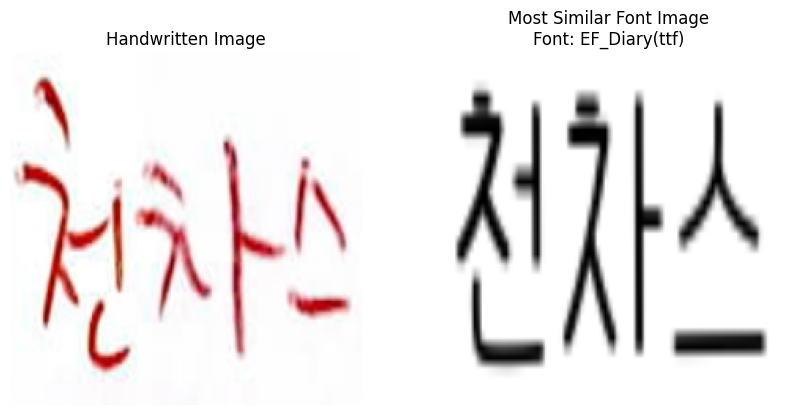

In [ ]:

# 손글씨 이미지 로드 및 전처리
handwritten_image_path = '/content/drive/MyDrive/Colab Notebooks/cropped_images/IMG_OCR_53_4PR_04358_crop_2_7LKc7LCo7Iqk.png'
handwritten_image = cv2.imread(handwritten_image_path)
handwritten_image = cv2.resize(handwritten_image, (224, 224)) / 255.0


# 가장 유사한 폰트 이미지 찾기
most_similar_image, most_similar_label, similarity_score = find_best_matching_font_image(handwritten_image, images, labels, model)

if most_similar_image is not None:
    print(f"Most similar font image found with similarity score: {similarity_score}")
    print(f"Font name: {most_similar_label[1]}")  # 폰트명 출력

    # 손글씨 이미지와 가장 유사한 폰트 이미지 출력
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Handwritten Image')
    plt.imshow(handwritten_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f'Most Similar Font Image\nFont: {most_similar_label[1]}')
    plt.imshow(most_similar_image, cmap='gray')
    plt.axis('off')

    plt.show()
else:
    print("No similar font image found.")


In [ ]:
# 텍스트 가지고 폰트 이미지 만들기

##
# font 파일 목록 정리
path = 'data/font/'
fonts_path_list = list(map(lambda x: path + str(x), filter(lambda x: x.endswith('.ttf'), os.listdir(path))))
fonts_list = list(map(lambda x:str(x), filter(lambda x: x.endswith('.ttf'), os.listdir(path))))

if len(fonts_path_list) == len(fonts_list):
    print('font 갯수: {}'.format(len(fonts_list)))
    print('폰트 경로 예시: {}'.format(fonts_path_list[0]))
    print('폰트 이름 예시: {}'.format(fonts_list[0]))



In [ ]:
def font2image(df):

    # def df2var(row):

    #     name = str(row['id'][12:])
    #     texts = row['text']

    #     return name, texts

    def txt2image(path, fontName, name, draw_text):

        font = ImageFont.truetype(path, 25)

        # 텍스트 크기 계산
        # 참고 코드는 getsize 였으나 함수의 이름과 활용이 바뀜
        bbox = font.getbbox(draw_text)

        w = bbox[2] - bbox[0]
        h = bbox[3]


        # 이미지 사이즈 지정
        text_width = int(w * 1.1)
        text_height = int(h * 1.2)

        # 이미지 객체 생성 (배경 흰색)
        canvas = Image.new('RGB', (text_width, text_height), "white")

        # 가운데에 그리기 (폰트 색: 검정)
        draw = ImageDraw.Draw(canvas)

        # 텍스트 그리기
        draw.text(((text_width - w) / 2.0,
                  (text_height - h) / 3.0),
                  draw_text, 'black', font)

        # png로 저장 및 출력해서 보기
        file_name = 'result/' + name + '_' + draw_text + '_' + fontName +'.png'
        canvas.save(file_name, "PNG")

        # 결과물 바로 출력하기
#         canvas.show()

    print('적용 폰트 갯수: {}'.format(len(fonts_path_list)))
    print('적용 폰트 리스트')
    for path in fonts_path_list:
        font = path[10:-4]

    # 이부분이 리스트가 아니라 텍스트로 반환하면 되는 것

    for idx, row in df.iterrows():
        name, texts = df2var(row)
        for path in fonts_path_list:
            font = path[10:-4]
            for text in texts:
                txt2image(path, font, name, text)

        print('적용 파일 이름: {}, 변환 단어: {}'.format(name, texts))

In [ ]:
# 모든 폰트에 적용됨
# 입력값은

font2image(data[:3])